In [1]:
%matplotlib inline

In [2]:
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore") 
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.loops import from_array
import config_qubit as config
from progress import addjob

2025-09-30 09:06:41,765 - qm - INFO     - Starting session: 86296d97-c55f-4f1c-8659-3da2a9503673


/opt/tljh/user/lib/python3.12/site-packages/qm/results/__init__.py:15: DeprecationWarning: qm.results is deprecated since "1.2.3" and will be removed in "1.3.0". If you need anything from this module, import it directly from `qm` or from `qm.simulate` for simulator-related functionality.
  warnings.warn(


In [3]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-09-30 09:06:46,949 - qm - INFO     - Performing health check
2025-09-30 09:06:46,954 - qm - INFO     - Health check passed


# Connect to the running QM

In [4]:
# Get the## QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1695779081588


# Exercise 0: Check Rabi period
Modify the amplitude of the pulse with the `amp` directive and observe how the Rabi oscillation frequency is modified

2025-09-30 09:08:29,995 - qm - INFO     - Sending program to QOP for compilation

Job is running


Text(0.5, 0, 'Pulse Duration [ns]')

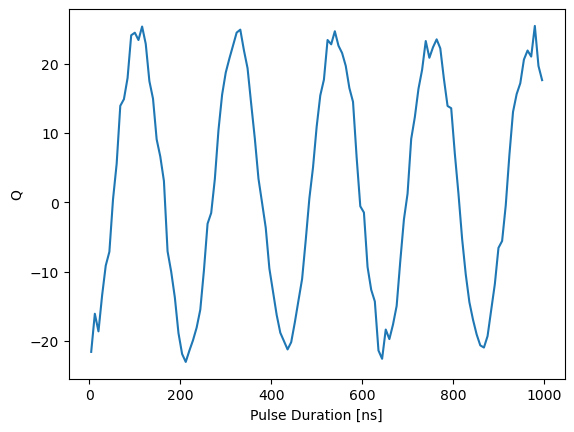

In [5]:
# Parameters Definition
n_avg = 500  # The number of averages
# Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
t_min = 4 // 4
t_max = 1000 // 4
dt = 8 // 4
durations = np.arange(t_min, t_max, dt)
thermalization_time = 80 #in µs

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    t = declare(int)  # QUA variable for the qubit pulse duration
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature

    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the pulse duration
            play("trigger","trigger")
            # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
            play("pi"*amp(1.0), "qubit", duration=t)
            # Align the two elements to measure after playing the qubit pulse.
            align("qubit", "resonator")
            # Measure the state of the resonator
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I, I_st)
            save(Q, Q_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.buffer(len(durations)).average().save("I")
        Q_st.buffer(len(durations)).average().save("Q")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)

# Wait for results
results=fetching_tool(job, data_list=["I", "Q"], mode="wait_for_all")
I, Q = results.fetch_all()

# Create plot
theta = -292*np.pi/180
Ir =  I*np.cos(theta)-Q*np.sin(theta)
fig,ax = plt.subplots()
ax.plot(4*durations, Ir*1e4)
ax.set_ylabel("I")
ax.set_xlabel("Pulse Duration [ns]")

## Exercise 1: Gaussian pulse adjustment
The goal is to find the amplitude of the MW to rotate the qubit by $\pi$ using the predefined gaussian pulse duration
- Play the `x180` pulse on the qubit and modify its amplitude in a loop with the `amp` directive
- Plot the I,Q components of the readout signal as a function of the amplitude

2025-09-30 09:09:33,531 - qm - INFO     - Sending program to QOP for compilation

Job is running


Text(0.5, 0, 'Pulse Amplitude Modifier')

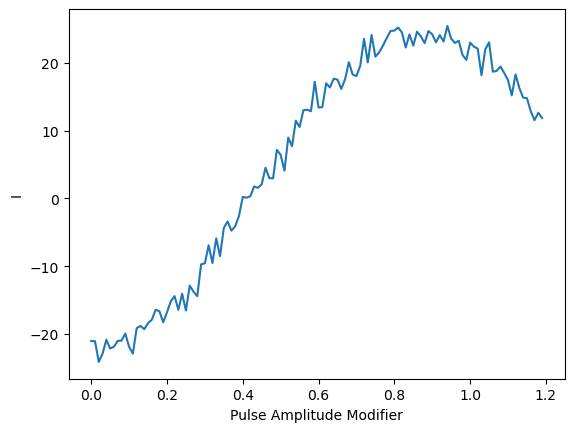

In [7]:
# Parameters Definition
n_avg = 500  # The number of averages
amplitudes = np.arange(0, 1.2, 0.01)
thermalization_time = 80 #in µs

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    amplitude = declare(fixed)  
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature
    n_st = declare_stream()  # Stream for the averaging iteration 'n'

    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(amplitude, amplitudes)): 
            # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
            play("x180"*amp(1.0), "qubit") # <--- Modify to change the amplitude with the loop variable
            # Align the two elements to measure after playing the qubit pulse.
            align("qubit", "resonator")
            # Measure the state of the resonator
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I, I_st)
            save(Q, Q_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.buffer(len(amplitudes)).average().save("I")
        Q_st.buffer(len(amplitudes)).average().save("Q")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)

# Wait for results
results=fetching_tool(job, data_list=["I", "Q"], mode="wait_for_all")
I, Q = results.fetch_all()

# Create plot
theta = -292*np.pi/180
Ir =  I*np.cos(theta)-Q*np.sin(theta)
fig,ax = plt.subplots()
ax.plot(amplitudes, Ir*1e4)
ax.set_ylabel("I")
ax.set_xlabel("Pulse Amplitude Modifier")

## Exercise 2: Determine the qubit excited state lifetime ($T_1$) 
- Write a sequence where the qubit is prepared in $|1\rangle$ at the beginning using a `x180` pulse
- Delay the measurement by a varying time that is changed in a loop
- Plot the I,Q components of the readout signal as a function of the delay
- Estimate the $T_1$ time of the qubit

2025-09-30 09:13:25,698 - qm - INFO     - Sending program to QOP for compilation

Job is running


Text(0.5, 0, 'Pulse Duration [µs]')

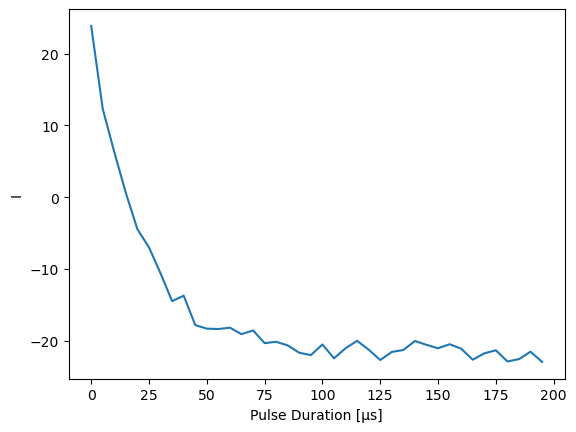

In [13]:
# Parameters Definition
n_avg = 2000  # The number of averages
# Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
t_min = 4 // 4
t_max = 200000 // 4
dt = 10000 // 4
durations = np.arange(t_min, t_max, dt)
thermalization_time = 80 #in µs

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    t = declare(int)  # QUA variable for the qubit pulse duration
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature

    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the waiting time
            # write the sequence    
            play("x180"*amp(0.88),"qubit")
            align("qubit","resonator")
            wait(t)
            # Measure the state of the resonator
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I, I_st)
            save(Q, Q_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.buffer(len(durations)).average().save("I")
        Q_st.buffer(len(durations)).average().save("Q")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)

# Wait for results
results=fetching_tool(job, data_list=["I", "Q"], mode="wait_for_all")
I, Q = results.fetch_all()

# Create plot
theta = -292*np.pi/180
Ir =  I*np.cos(theta)-Q*np.sin(theta)
fig,ax = plt.subplots()
ax.plot(4*durations*1e-3, Ir*1e4)
ax.set_ylabel("I")
ax.set_xlabel("Pulse Duration [µs]")

## Exercise 3: Determine the qubit phase coherence time ($T_2$) 
- Read on the [Ramsey sequence](https://qiskit-community.github.io/qiskit-experiments/manuals/characterization/t2ramsey.html)
- Write the Ramsey sequence in qua using two `x90` pulses separated by a varying delay that is changed in a loop
- Also include a `frame_rotation_2pi` command that rotates the frame by a phase proportional to the delay (use addition or multiplication, you may be interested in reading about [casting](https://docs.quantum-machines.co/latest/docs/API_references/qua/cast/))
- Plot the I,Q components of the readout signal as a function of the delay
- Estimate the $T_2$ time of the qubit

## Exercise 4: Spectroscopy of the $|1\rangle \rightarrow |2\rangle$ transition
- Starting from the qubit spectroscopy sequence in ``Transmon Demo``, write a sequence to perform the spectroscopy of the $|2\rangle$ state